<a href="https://colab.research.google.com/github/Rhayem1920/PCA-for-Enhancing-Speed-and-Accuracy-Bitcoin-Strategy/blob/main/Bitcoin_Trading_Enhancing_Speed_and_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Problem Definition**

**I will use the dimensionality reduction approach to enhance the “bitcoin trading strategy” project.**

**The data and the variables used in this case study are same as the case study presented the previous Project. The data is the bitcoin data for the time period of Jan 2012 to October 2017, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency and weighted bitcoin price**


In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

from mpl_toolkits.mplot3d import Axes3D

import re
from collections import OrderedDict
from time import time
import sqlite3       

from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interactive, fixed


In [2]:
dataset = pd.read_csv('/content/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

dataset.head()


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


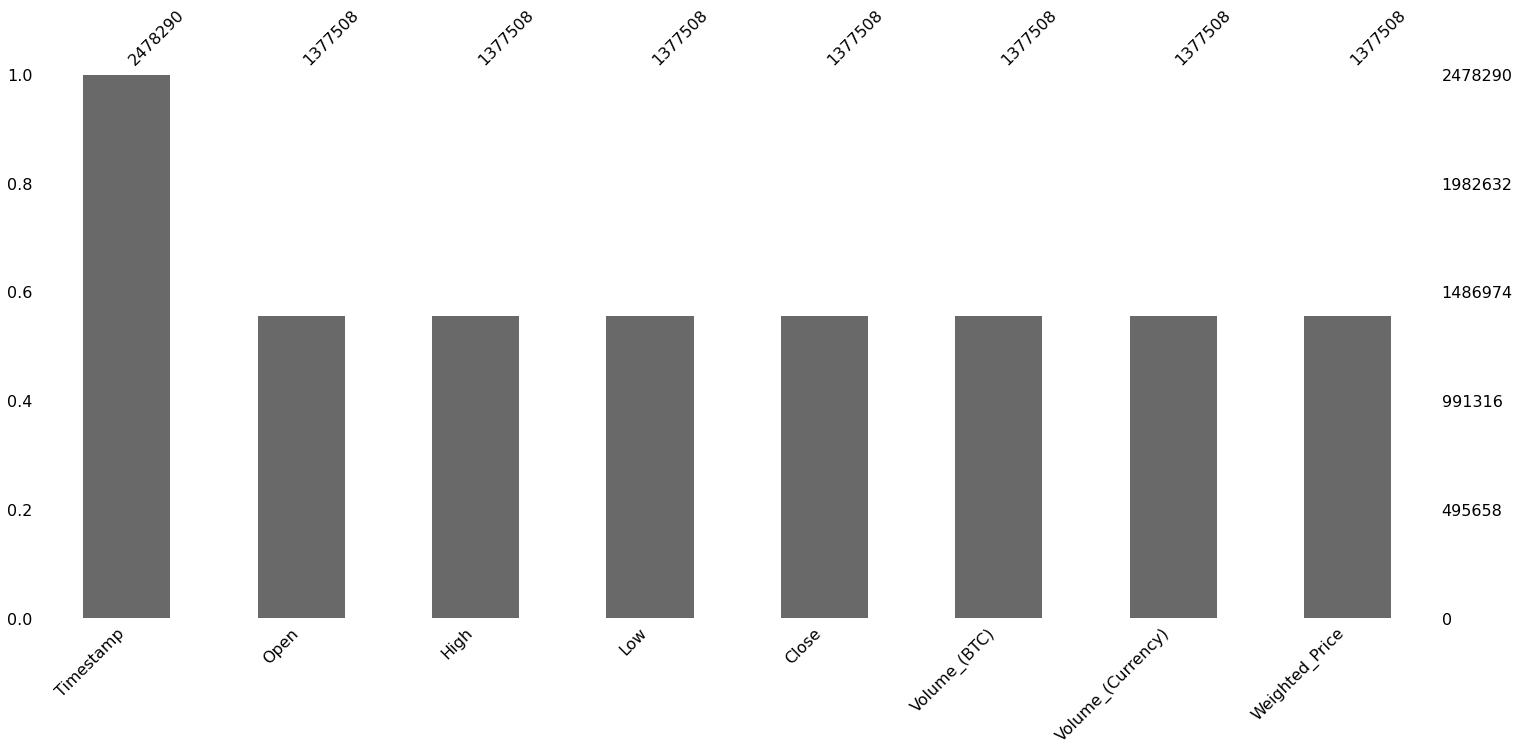

In [3]:
import missingno as msno
msno.bar(dataset)

## **Exploratory Data Analysis**

In [4]:
# shape
print(dataset.shape)


# peek at data
set_option('display.width', 100)
dataset.tail(5)



(2478290, 8)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2478285,1474403340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2478286,1474403400,606.42,606.42,606.42,606.42,0.043795,26.558024,606.420000
2478287,1474403460,607.67,607.67,607.67,607.67,0.079223,48.141604,607.670000
2478288,1474403520,607.67,607.67,606.44,607.67,0.556886,337.788001,606.565645
2478289,1474403580,606.42,606.44,606.42,606.44,1.000000,606.430000,606.430000


In [5]:
# describe data
set_option('precision', 3)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,2.478e+06,1.378e+06,1.378e+06,1.378e+06,1.378e+06,1.378e+06,1.378e+06,1.378e+06
mean,1.400e+09,3.804e+02,3.807e+02,3.801e+02,3.804e+02,1.284e+01,4.712e+03,3.804e+02
std,4.308e+07,2.141e+02,2.143e+02,2.138e+02,2.141e+02,4.373e+01,1.843e+04,2.140e+02
min,1.325e+09,3.800e+00,3.800e+00,1.500e+00,1.500e+00,0.000e+00,0.000e+00,3.800e+00
25%,1.362e+09,2.310e+02,2.310e+02,2.309e+02,2.310e+02,4.307e-01,1.176e+02,2.310e+02
50%,1.400e+09,3.735e+02,3.738e+02,3.733e+02,3.735e+02,1.963e+00,5.454e+02,3.735e+02
75%,1.437e+09,5.235e+02,5.242e+02,5.229e+02,5.235e+02,8.570e+00,2.645e+03,5.235e+02
max,1.474e+09,1.163e+03,1.163e+03,1.163e+03,1.163e+03,5.854e+03,1.866e+06,1.163e+03


### **Data Cleaning**


In [6]:

#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [7]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

dataset=dataset.drop(columns=['Timestamp'])

## **Preparing the data for classification**

We attach a label to each movement:

    1 if the signal is that short term price will go up as compared to the long term.
    0 if the signal is that short term price will go down as compared to the long term.



In [8]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
2478285,607.67,607.67,607.67,607.67,0.308,186.947,607.670,607.676,607.158,1.0
2478286,606.42,606.42,606.42,606.42,0.044,26.558,606.420,607.549,607.149,1.0
2478287,607.67,607.67,607.67,607.67,0.079,48.142,607.670,607.547,607.160,1.0
2478288,607.67,607.67,606.44,607.67,0.557,337.788,606.566,607.545,607.172,1.0
2478289,606.42,606.44,606.42,606.44,1.000,606.430,606.430,607.422,607.163,1.0


In [9]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2478285,607.67,607.67,607.67,607.67,0.308,186.947,607.670,607.676,607.158,1.0,607.550,607.281,606.755,-0.003,0.003,-0.02,0.86,68.594,55.440,50.852,98.693,98.693,98.693,98.693,92.4,92.400,607.676,607.232,606.543
2478286,606.42,606.42,606.42,606.42,0.044,26.558,606.420,607.549,607.149,1.0,607.344,607.225,606.751,-0.209,-0.202,-1.27,-1.23,26.105,44.682,49.694,16.993,71.460,16.993,71.460,42.4,75.733,607.549,607.191,606.538
2478287,607.67,607.67,607.67,607.67,0.079,48.142,607.670,607.547,607.160,1.0,607.403,607.254,606.760,-0.003,0.003,-0.02,0.02,56.230,53.930,50.819,98.693,71.460,98.693,71.460,92.4,75.733,607.547,607.191,606.540
2478288,607.67,607.67,606.44,607.67,0.557,337.788,606.566,607.545,607.172,1.0,607.452,607.281,606.769,0.000,0.018,-0.02,0.02,56.230,53.930,50.819,100.000,71.895,98.693,71.460,92.4,75.733,607.545,607.192,606.542
2478289,606.42,606.44,606.42,606.44,1.000,606.430,606.430,607.422,607.163,1.0,607.268,607.226,606.766,-0.202,-0.191,-1.23,-1.12,37.606,45.857,49.714,1.600,66.764,18.301,71.895,43.2,76.000,607.422,607.155,606.537


In [10]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

dataset = dataset.dropna(axis=0)

dataset.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2478285,607.67,0.308,607.670,1.0,607.550,607.281,606.755,-0.003,0.003,-0.02,0.86,68.594,55.440,50.852,98.693,98.693,98.693,98.693,92.4,92.400,607.676,607.232,606.543
2478286,606.42,0.044,606.420,1.0,607.344,607.225,606.751,-0.209,-0.202,-1.27,-1.23,26.105,44.682,49.694,16.993,71.460,16.993,71.460,42.4,75.733,607.549,607.191,606.538
2478287,607.67,0.079,607.670,1.0,607.403,607.254,606.760,-0.003,0.003,-0.02,0.02,56.230,53.930,50.819,98.693,71.460,98.693,71.460,92.4,75.733,607.547,607.191,606.540
2478288,607.67,0.557,606.566,1.0,607.452,607.281,606.769,0.000,0.018,-0.02,0.02,56.230,53.930,50.819,100.000,71.895,98.693,71.460,92.4,75.733,607.545,607.192,606.542
2478289,606.44,1.000,606.430,1.0,607.268,607.226,606.766,-0.202,-0.191,-1.23,-1.12,37.606,45.857,49.714,1.600,66.764,18.301,71.895,43.2,76.000,607.422,607.155,606.537


## **Data Visualization**

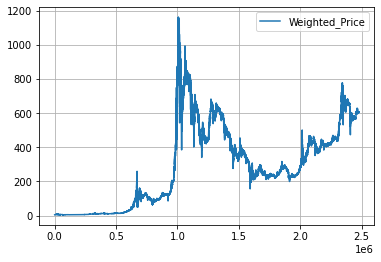

In [11]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

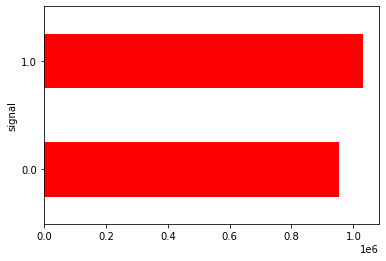

In [12]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()



**The predicted variable is upward 52.87% out of total data-size, meaning that number of the buy signals was higher than that of sell signals.**

## **Evaluate Algorithms and Models**

### **Train Test Split**

We split the dataset into 80% training set and 20% test set.



In [13]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-10000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

# Data Standardisation

# As a preprocessing step, let's start with normalizing the feature values so they standardised - this makes comparisons simpler and allows next steps for Singular Value Decomposition.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
# summarize transformed data
X_train.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,Close,Volume_(BTC),Weighted_Price,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2470741,0.379,-0.243,0.361,0.355,0.592,0.812,0.003,-1.029,0.026,-1.022,-0.267,-0.565,-0.500,1.058,0.347,-0.475,-0.938,-0.606,-1.111,0.285,0.708,0.833
2473233,-0.169,2.373,-0.630,-0.715,-0.908,-1.123,2.594,2.557,2.562,2.527,1.180,1.533,1.417,1.058,0.623,1.193,0.759,1.267,0.664,-0.778,-1.064,-1.209


# **Singular Value Decomposition-(Feature Reduction)**

**We want to reduce the dimensionality of the problem to make it more manageable, but at the same time we want to preserve as much information as possible.**

**Hence, we use a technique called singu‐ lar value decomposition (SVD), which is one of the ways of performing PCA.Singular Value Decomposition (SVD) is a matrix factorization commonly used in signal processing and data compression. We are using the TruncatedSVD method in the sklearn package.**

Variance preserved by first 5 components == 88.95%


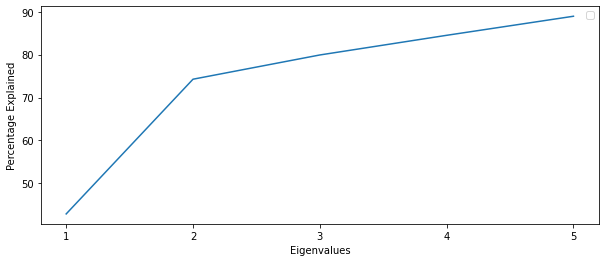

In [14]:
from matplotlib.ticker import MaxNLocator
ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
ax.legend("")
print('Variance preserved by first 5 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))



**We can preserve 92.75% variance by using just 5 components rather than the full 25+ original features.**




In [15]:
dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(8000, 5)


,c0,c1,c2,c3,c4
2470741,0.381,-1.975,-1.661,0.068,-0.807
2473233,-3.164,5.053,-0.586,0.618,3.212
2470615,-4.967,0.573,-0.803,0.127,-0.809
2471724,-2.136,1.628,1.031,0.057,-0.246
2475634,1.552,-2.672,-1.405,0.181,-1.145


## **Basic Visualisation of Reduced Features**

**Lets attempt to visualise the data with the compressed dataset, represented by the top 5 components of an SVD.**



In [16]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

## **Pairs Plots:**

**Pairs-plots are a simple representation using a set of 2D scatterplots, plotting each component against another component, and coloring the datapoints according to their classification (or type of signal).**



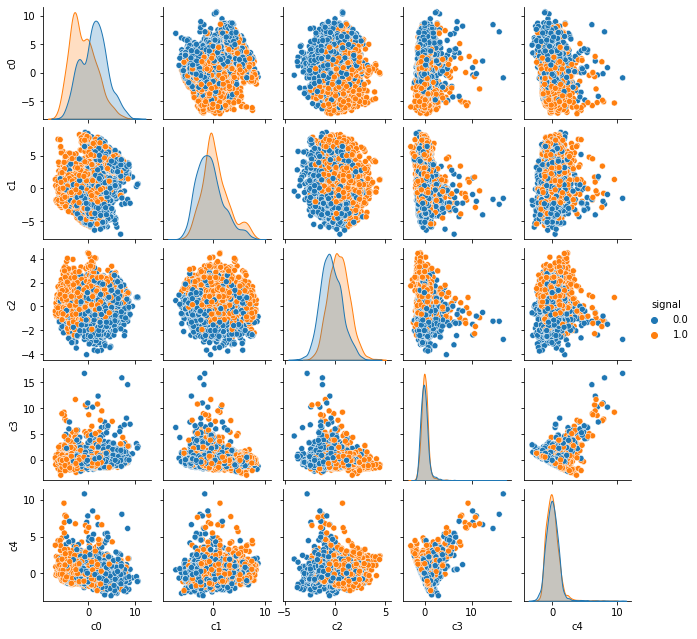

In [17]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['signal']=Y_train
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='signal', size=1.8)



###**Observation:**

  **In the scatter plot of each of the principal component, we can clearly that there is a clear segregation of the orange and blue dots, which means that data-points from the same type of signal tend to cluster together.**

  **However, it’s hard to get a full appreciation of the differences and similarities between data points across all the components, requiring that the reader hold comparisons in their head while viewing**


## **Other Dimensionality Technic: t-SNE visualization**

In this step, we implement another technique of dimensionality reduction - t-SNE and look at the related visualization.We will use the basic implementation available in scikit-learn



Text(0.5, 1.0, 'Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')

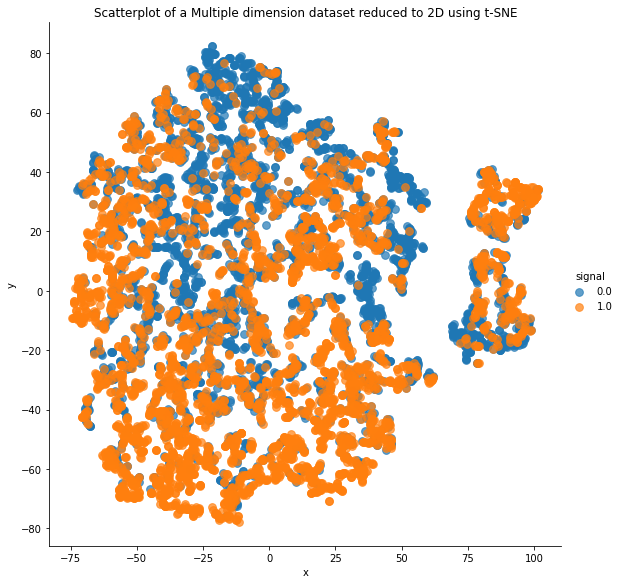

In [18]:
tsne = TSNE(n_components=2, random_state=0)

Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)

dftsne['signal'] = Y_train

g = sns.lmplot('x', 'y', dftsne, hue='signal', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')



### **Observation:**

This is quite interesting way of visualizing the trading signal data. The above plot shows us that there is a good degree of clustering for the trading signal. Although, there are some overap of the long and short signals, but they can be distinguished quite well using the reduced number of features.

**In Review:**

We have analyzed the bitcoin trading signal dataset in the following steps:

  We prepared the data by cleaning (removing character features values, replacing nans) and normalizing.

  We applied transformation during the feature reduction stage.

  We then visualized the data in the reduced dimentionality and ultimately applied t-SNE algorithm to reduce the data into two dimensions and visualize effectivly

## **Compare Models-with and without dimensionality Reduction**



In [23]:
# test options for classification
scoring = 'accuracy' 
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

#### **Models:**



In [24]:
import time
start_time = time.time()
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
# spot check the algorithms
models =  RandomForestClassifier(n_jobs=-1)
cv_results_XTrain= cross_val_score(models, X_train, Y_train, cv=num_folds, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 24.789278984069824 seconds ---


In [25]:
start_time = time.time()
X_SVD= dfsvd[svdcols].iloc[:,:5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=num_folds, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 11.568941354751587 seconds ---


In [26]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Result without dimensionality Reduction: 0.888000 (0.012993)
Result with dimensionality Reduction: 0.784250 (0.014000)




Looking at the model results, we do not deviate that much from the accuracy, and the accuracy just decreases from 93.6% to 88.7%. However, there is a 4 times improve‐ ment in the time taken, which is significant.

**Conclusion:**

With dimensionality reduction, we achieved almost the same accuracy with four times improvement in the time. In trading strategy development, when the datasets are huge and the number of features is big such improvement in time can lead to a significant improvement in the entire process.

We demonstrated that both SVD and t-SNE provide quite interesting way of visualizing the trading signal data, and provide a way to distinguished long and short signals of a trading strategy with reduced number of features.
